# State diagrams for simple circuits in dinkum

In [1]:
from IPython.display import Image

import dinkum
from dinkum.vfg import Gene, Receptor
from dinkum.vfn import Tissue
from dinkum import Timecourse

from dinkum.display import MultiTissuePanel, tc_record_activity

## Coherent feed forward

Gene Z is turned on only once both X and Y are on, inducing a delay.

start=1 stop=5


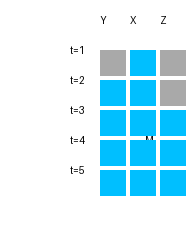

In [2]:
dinkum.reset()

# set it all up!                                                            
x = Gene(name='X')
y = Gene(name='Y')
z = Gene(name='Z')

y.activated_by(source=x)
z.activated_by_and(sources=[x, y])

m = Tissue(name='M')
x.is_present(where=m, start=1)

states, tissues, is_active_fn = tc_record_activity(stop=5)

#panel = TissueActivityPanel(states=states, tissue_name='M')
mp = MultiTissuePanel(states=states, tissue_names=['M'],
                      save_image="coherent_feed_forward.png",
#                      canvas_type='ipycanvas'
                     )
mp.draw(is_active_fn)

## Incoherent feed forward

Here gene Z is on for only a brief period of time.

start=1 stop=5


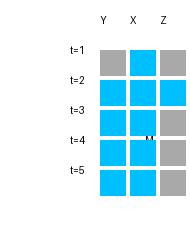

In [3]:
dinkum.reset()

x = Gene(name='X')
y = Gene(name='Y')
z = Gene(name='Z')

y.activated_by(source=x)
z.and_not(activator=x, repressor=y)

m = Tissue(name='M')
x.is_present(where=m, start=1)

# run!                                                                      
states, tissues, is_active_fn = tc_record_activity(stop=5)
mp = MultiTissuePanel(states=states, tissue_names=['M'],
                      save_image="incoherent_feed_forward.png")
mp.draw(is_active_fn)


## Incoherent feed forward in two tissues

Here, gene S switches specification state b/t the two tissues.

start=1 stop=8


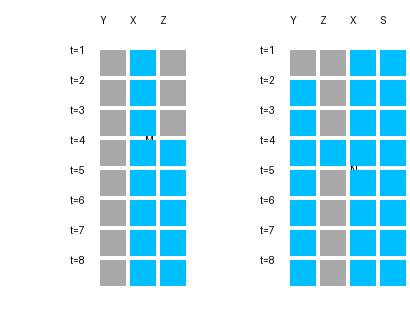

In [4]:
dinkum.reset()

# set it all up!                                                            
x = Gene(name='X')
y = Gene(name='Y')          # Y should be on in tissue N
z = Gene(name='Z')          # Z should be on in tissue M?
s = Gene(name='S')          # switches spec states b/t tissues M and N      

y.activated_by_and(sources=[x, s])    # Y requires S => on in tissue N
z.and_not(activator=x, repressor=y, delay=3)   # Z is on, only when Y is not around (so, not S)

m = Tissue(name='M')
x.is_present(where=m, start=1)

m = Tissue(name='N')
x.is_present(where=m, start=1)
s.is_present(where=m, start=1)

# run!                                                                      
states, tissues, is_active_fn = tc_record_activity(stop=8)
mp = MultiTissuePanel(states=states, tissue_names=['M', 'N'],
                      save_image="incoherent_feed_forward_2.png")
mp.draw(is_active_fn)

## Mutual repression

Either A is present (and then X is on) or B is present (and Y is on)

start=1 stop=5


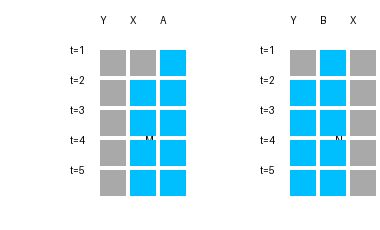

In [5]:
dinkum.reset()

# set it all up!                                                            
x = Gene(name='X')
y = Gene(name='Y')
a = Gene(name='A')
b = Gene(name='B')

x.and_not(activator=a, repressor=y)
y.and_not(activator=b, repressor=x)

m = Tissue(name='M')
a.is_present(where=m, start=1)

n = Tissue(name='N')
b.is_present(where=n, start=1)

# run!                                                                      
states, tissues, is_active_fn = tc_record_activity(stop=5)
mp = MultiTissuePanel(states=states, tissue_names=['M', 'N'],
                      save_image="mutual_repression.png")
mp.draw(is_active_fn)

## Toggle switch

When co-factor is present, X is repressed; otherwise, X is expressed.

start=1 stop=5


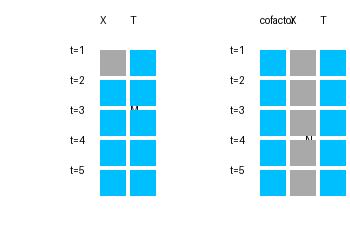

In [6]:
dinkum.reset()

# set it all up!                                                            
x = Gene(name='X')          # target of toggle switch                       
t = Gene(name='T')          # toggle switch t.f.                            
cofactor = Gene(name='cofactor')    # janus factor                          

x.toggle_repressed(tf=t, cofactor=cofactor)

# tissue M: t is present, cofactor is not; activate.                        
m = Tissue(name='M')
t.is_present(where=m, start=1)

# tissue N: t is present, along with cofactor; repress.                     
n = Tissue(name='N')
t.is_present(where=n, start=1)
cofactor.is_present(where=n, start=1)

# run!                                                                      
states, tissues, is_active_fn = tc_record_activity(stop=5)
mp = MultiTissuePanel(states=states, tissue_names=['M', 'N'],
                      save_image="toggle_switch.png")
mp.draw(is_active_fn)

## Community effect

An initial pulse of A in one cell results in eventual signalling-based lock-on of Y in territory.

start=1 stop=10


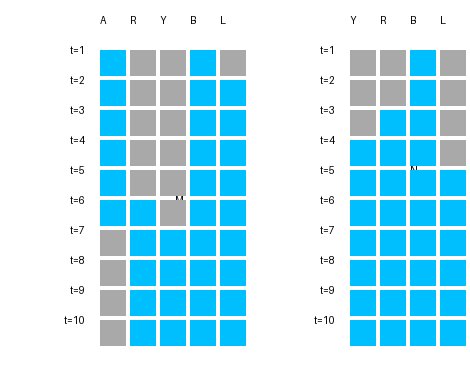

In [7]:
dinkum.reset()

# two tissues                                                               
m = Tissue(name='M')
n = Tissue(name='N')

# neighbors                                                                 
m.add_neighbor(neighbor=n)
n.add_neighbor(neighbor=m)
assert n in m.neighbors     # should this be bidirectional? probably. CTB.  
assert m in n.neighbors

# VFN:                                                                      
a = Gene(name='A')          # transient input in M to turn on ligand L      
m.add_gene(gene=a, start=1, duration=6)

b = Gene(name='B')          # permanent input in M and N to turn on receptor R                                                                             
m.add_gene(gene=b, start=1)
n.add_gene(gene=b, start=1)

# VFG:                                                                      
ligand = Gene(name='L')          # ligand                                   
r = Receptor(name='R')      # receptor                                      
y = Gene(name='Y')          # activated by R                                

ligand.activated_or(sources=[a, y])

r.ligand(activator=b, ligand=ligand) # expression driven by B,              
                                     # activated by ligand                  
y.activated_by(source=r)    # transcription of Y turned on by activated R.  

# run!                                                                      
states, tissues, is_active_fn = tc_record_activity(stop=10)
mp = MultiTissuePanel(states=states, tissue_names=['M', 'N'],
                      save_image="community_effect.png")
mp.draw(is_active_fn)